# Анализ результатов A/B теста новой платежной воронки

## Введение

В данном исследовании рассматриваются **результаты A/B тестирования** новой платежной воронки с целью анализа поведения пользователей и оценки влияния изменений на ключевые метрики.

Полученные результаты помогут определить, насколько предложенные улучшения положительно сказываются на конверсии, пользовательском опыте и общем качестве взаимодействия с платежной системой, что поможет принять решение о применении изменений.

## Описание данных

**ab_participants.csv** - таблицы с участниками теста

- user_id - id пользователя
- group - какой группе принадлежит пользователь
- ab_test - в каком тесте пользователь участвует

**ab_events.csv** - таблица с маркетинговыми событиями
- name - название события
- regions - регионы, в которых событие проводилось
- start_dt - дата начала события
- finish_dt - дата окончания события

**ab_new_users.csv** - таблица с новыми пользователями
- user_id - id пользователя
- first_date - дата добавления пользователя в тест
- region - регион пользователя
- device - с какого устройства была регистрация

**final_ab_events.csv** - таблица с действиями новых пользователей
- user_id - id пользователя
- event_dt - дата события
- event_name - тип действия
- details - дополнительные данные, если действием является покупка, то здесь хранится стоимость покупки

## Постановка задачи

Необходимо проанализировать итоги теста **recommender_system_test**. <br>
**Группа A** - контрольная, **B** - тестовая (новая платежная воронка). <br>
**Дата запуска**: 07-12-2020. **Дата остановки набора новых пользователей**: 21-12-2020 **Дата окончания**: 04-01-2021. <br>
**Аудитория** - EU <br>
**Ожидаемое количество участников** - 6000. <br>
**Ожидаемый эффект** - за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%.<br>
**Исследуемые метрики**:
- конверсия в просмотр карточек - **product_page**
- конверсия корзины - **product_cart**
- покупки **purchase**

## План работы
<font size="4"> <ol>
   <li> Загрузка и предобработка данных </li>
    <li> Проверка данных на соответсвие требованиям</li>
    <li> Исследовательский анализ данных, визуализация</li>
    <li> A/B тестирование. Использование статистических критериев для анализа результатов</li>
    <li> Вывод </li></ol></font>

## Загрузка и предобработка данных

In [151]:
# Импорт библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import plotly.graph_objects as go
from statsmodels.stats.proportion import proportions_ztest

from scipy import stats
import statsmodels as sts

plt.style.use('seaborn-v0_8-deep')
%matplotlib inline
pd.options.display.max_columns = 20

In [152]:
import warnings
warnings.filterwarnings('ignore')

Загрузим таблицы

In [153]:
ab_events = pd.read_csv('data/ab_events.csv')
ab_new_users = pd.read_csv('data/ab_new_users.csv')
ab_participants = pd.read_csv('data/ab_participants.csv')
final_ab_events = pd.read_csv('data/final_ab_events.csv')

Посмотрим на данные и выведем основную информацию о каждом датасете

**ab_events**

In [154]:
display(ab_events.head())
ab_events.info()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


**ab_new_users**

In [155]:
display(ab_new_users.head())
ab_new_users.info()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


**ab_participants**

In [156]:
display(ab_participants.head())
ab_participants.info()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


**final_ab_events**

In [157]:
display(final_ab_events.head())
final_ab_events.info()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


Как мы видим во всех датасетах, кроме **final_ab_events** нет пропущенных значений. В таблице **final_ab_events** пропущенные значения встречаются только в столбце `details`, но как говорилось выше в этом столбце значения присутсвуют только для строк, означающих покупку, поэтому эти пропуски можно никак не обрабатывать

Проверим данные на наличие дубликатов

In [158]:
def dupl_check(df:pd.DataFrame) -> None:
    print('Количество дубликатов в таблице:')
    print(df.duplicated().sum())

In [159]:
print('ab_events')
dupl_check(ab_events)

ab_events
Количество дубликатов в таблице:
0


In [160]:
print('ab_new_users')
dupl_check(ab_new_users)

ab_new_users
Количество дубликатов в таблице:
0


In [161]:
print('ab_participants')
dupl_check(ab_participants)

ab_participants
Количество дубликатов в таблице:
0


In [162]:
print('final_ab_events')
dupl_check(final_ab_events)

final_ab_events
Количество дубликатов в таблице:
0


В данных не обнаружилось дубликатов

**Преобразуем столбцы к нужным типам данных**

Во всех таблицах столбцы с датами имеют тип `object`, приведем к типу `datetime`

In [163]:
ab_events.columns

Index(['name', 'regions', 'start_dt', 'finish_dt'], dtype='object')

In [164]:
ab_events.head(1)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


In [165]:
ab_events['start_dt'] = pd.to_datetime(ab_events['start_dt'], format = '%Y-%m-%d')
ab_events['finish_dt'] = pd.to_datetime(ab_events['finish_dt'], format = '%Y-%m-%d')

In [166]:
ab_new_users.head(1)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC


In [167]:
ab_new_users['first_date'] = pd.to_datetime(ab_new_users['first_date'], format = '%Y-%m-%d')

In [168]:
final_ab_events.head(1)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99


In [169]:
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'], format = '%Y-%m-%d %H:%M:%S')

In [170]:
display(ab_events.info())
display(ab_new_users.info())
display(final_ab_events.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 580.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


None

<div style="border:solid black 4px; padding: 10px">
    
Мы загрузили и предобработали данные. <br> Убедились что в данных нет дубликатов, объяснили содержащиеся в таблице **final_ab_events** нулевые значения. <br>Преобразовали столбцы, содержащие дату и время к нужному типу данных

</div>

## Проверка данных на соответсвие требованиям теста

Сначала посмотрим в каких тестах учавствовали пользователи из таблицы `ab_participants`

In [171]:
ab_participants.ab_test.unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

Есть ли пользователи, которые учавствуют в двух тестах сразу

In [172]:
ab_participants['user_id'].duplicated().sum()

1602

1602 пользователя учавствовали в тесте *interface_eu_test* и *recommender_system_test* <br>
Проверим, как распределены пользователи по группам в тесте *recommender_system_test*, которые учавствовали сразу в двух тестах

In [173]:
(ab_participants[ab_participants['user_id'].isin\
(ab_participants[(ab_participants['ab_test'] == 'interface_eu_test') & (ab_participants['group'] == 'B')]['user_id'].values)])\
.query('ab_test == "recommender_system_test"')['group'].value_counts()

group
A    439
B    344
Name: count, dtype: int64

In [174]:
ab_participants[ab_participants.ab_test == 'recommender_system_test'].group.value_counts()

group
A    3824
B    2877
Name: count, dtype: int64

In [175]:
print(344/(344+439), 2877/(2877+3824))

0.4393358876117497 0.42933890464109836


Распределение пользователей, которые учавстовали в тесте *interface_eu_test* в группе B в нашем рассматриваемом тесте *recommender_system_test* близко к распределению всех пользователей в тесте *recommender_system_test*. Это означает что *interface_eu_test* имел одинаковое влияние на обе группы в нашем наблюдаемом тесте, а значит не должен как-либо исказить результаты

Отфильтруем данные только для рассматриваемого теста

In [176]:
ab_participants = ab_participants[ab_participants.ab_test == 'recommender_system_test']

Дата запуска теста: 07-12-2020, Дата окончания: 04-01-2021. <br> Проверим проводились ли в это время какие-то маркетинговые компании, которые могли повлиять на результат тест

In [177]:
# Проверим корректность групп пользователей
ab_participants.group.unique()

array(['A', 'B'], dtype=object)

In [178]:
ab_events.query('finish_dt >= "2020-12-07" or start_dt >= "2020-12-07"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Как мы видим параллельно нашему тесту также проводились две маркетинговые компании. <br>
Это стоит учитывать при принятии решений на основе A/B теста

In [179]:
ab_new_users.head(3)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC


Проверим, соотвуствуют ли даты регистрации новых пользователей указанным требованиям

In [180]:
print('Самая ранняя регистрация: ', ab_new_users.first_date.min())
print('Самая поздняя регистрация: ', ab_new_users.first_date.max())

Самая ранняя регистрация:  2020-12-07 00:00:00
Самая поздняя регистрация:  2020-12-23 00:00:00


Согласно требованиям дата остановки набора пользователей - 2020-12-21 <br>
Уберем записи не подходящие под это ограничение

In [181]:
ab_new_users = ab_new_users[ab_new_users.first_date <= '2020-12-21']

In [182]:
print('Самая ранняя регистрация: ', ab_new_users.first_date.min())
print('Самая поздняя регистрация: ', ab_new_users.first_date.max())

Самая ранняя регистрация:  2020-12-07 00:00:00
Самая поздняя регистрация:  2020-12-21 00:00:00


Теперь отсортируем аудиторию по региону, в требования указано, что в данном случае рассматриваем только аудиторию из Европы

In [183]:
ab_new_users.region.value_counts()

region
EU           42340
N.America     8347
CIS           2900
APAC          2883
Name: count, dtype: int64

In [184]:
ab_new_users = ab_new_users[ab_new_users.region == 'EU']

Объеденим таблицы в одну, с которой будем работать далее

In [185]:
merged = ab_participants.merge(ab_new_users, on = 'user_id')
merged = merged.merge(final_ab_events, how = 'left', on = 'user_id')
merged

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN
...,...,...,...,...,...,...,...,...,...
26285,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-15 20:10:06,product_page,NaN
26286,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-20 20:01:34,product_page,NaN
26287,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-14 05:48:50,login,NaN
26288,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-15 20:10:03,login,NaN


In [186]:
# Сколько всего уникальных пользователей мы рассматриваем
len(merged.user_id.unique())

6351

Посмотрим на итоговое распределение пользователей по группам

In [187]:
print('Пользователей попало в группу A:', merged[merged.group == 'A'].user_id.nunique(), \
      round(merged[merged.group == 'A'].user_id.nunique()/len(merged.user_id.unique()), 2))
print('Пользователей попало в группу B:', merged[merged.group == 'B'].user_id.nunique(),\
      round(merged[merged.group == 'B'].user_id.nunique()/len(merged.user_id.unique()), 2))

Пользователей попало в группу A: 3634 0.57
Пользователей попало в группу B: 2717 0.43


Так как до этого мы отфильтровали датасеты по столбцам `ab_test` и `region`, то их можно удалить

In [188]:
print(merged.region.unique())
print(merged.ab_test.unique())

['EU']
['recommender_system_test']


In [189]:
df = merged
df = df.drop(columns=['ab_test', 'region'], axis = 1)
df.head(5)

,user_id,group,first_date,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:29,product_cart,NaN
3,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-25 00:04:57,product_cart,NaN
4,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:27,product_page,NaN


<div style="border:solid black 4px; padding: 10px">

Мы отфильтровали данные по указанным требованиям <br>
Удалили пользователей входившиъх только в конкурирующий тест **interface_eu_test** <br>
Выяснили что пользователи, учавствовавшие в двух тестах распределены равномерно и маловероятно повлияют на результат теста <br>
Убрали записи о пользователях, зарегистрировавшихся позднее указанной в требованиях дате <br>
Отфильтровали пользователей по региону - оставили только Европу <br>
Объединили три таблицы в одну, удалили ненужные столбцы
</div>

## Исследовательский анализ данных

Сначала посмотрим на то как набирали пользователей в тест

In [190]:
regs = df.groupby(['user_id',  'group'], as_index = False)[['first_date']].min().sort_values('first_date')
regs_byday = regs.groupby(['first_date', 'group'], as_index = False)['user_id'].count().sort_values('first_date')
regs_byday.head(5)

,first_date,group,user_id
0,2020-12-07,A,349
1,2020-12-07,B,259
2,2020-12-08,A,186
3,2020-12-08,B,149
4,2020-12-09,A,143


Text(0, 0.5, 'Количество пользователей')

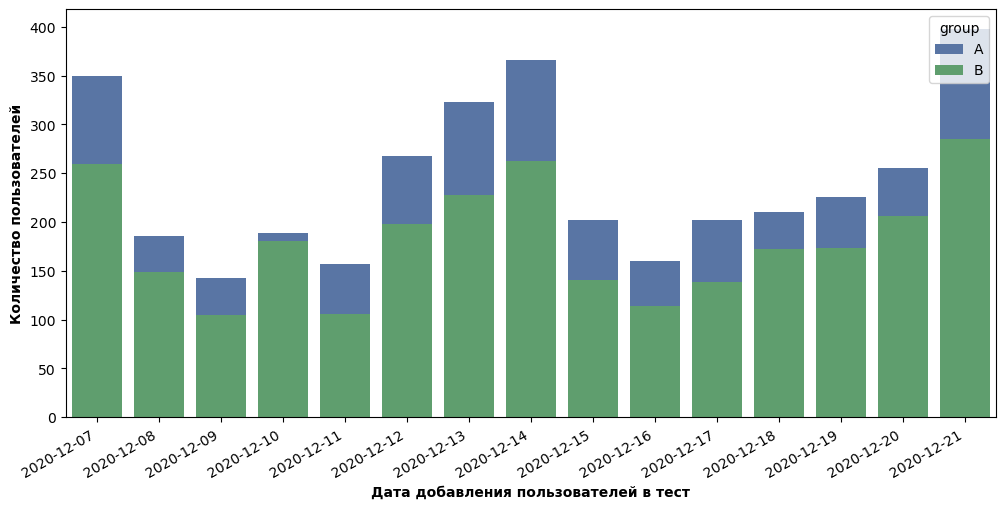

In [191]:
fig = plt.figure(figsize = (12, 6))
sns.barplot(data = regs_byday, x = 'first_date', y = 'user_id', hue = 'group', dodge = False)
plt.gcf().autofmt_xdate()
plt.xlabel('Дата добавления пользователей в тест', weight = 'bold')
plt.ylabel('Количество пользователей', weight = 'bold')

На этом графике представлено **распределение количества добавлений пользователей по дням**. <br>
Сильных отклонений в **отношении количества добавленных пользователей в группу B и группу A** в каждый отдельный день не замечено. Значит распределение пользователей по группам каждый день производилось равномерно

Теперь посмотрим на то, какие действия совершали пользователи на сайте

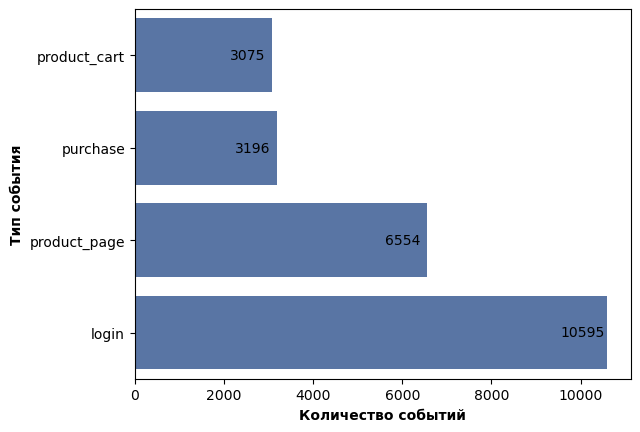

In [192]:
order = df.event_name.value_counts().sort_values().index
ax = sns.countplot(data = df, y = 'event_name', order = order)
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width()-700, p.get_y() + p.get_height() / 2.),
                ha='center', va='center', 
                xytext=(5, 0), textcoords='offset points')
plt.xlabel('Количество событий', weight = 'bold')
plt.ylabel('Тип события', weight = 'bold');

Есть ли сильные различия в поведении двух групп?

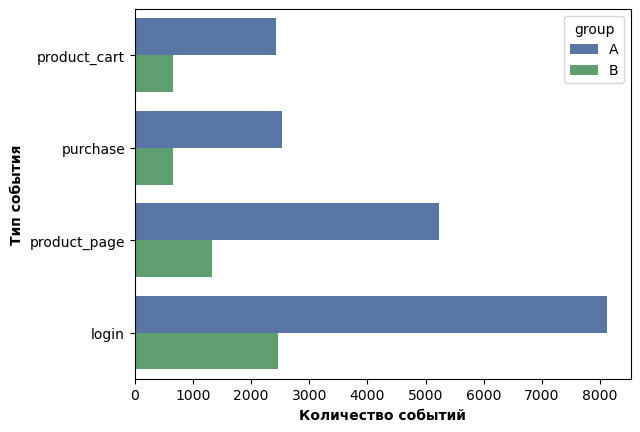

In [193]:
sns.countplot(data = df, y = 'event_name', order = order, hue = 'group')
plt.xlabel('Количество событий', weight = 'bold')
plt.ylabel('Тип события', weight = 'bold');

In [194]:
(df.groupby('user_id', as_index = False)[['group']].min()).group.value_counts()

group
A    3634
B    2717
Name: count, dtype: int64

Мы видим, что **пользователи из группы B намного меньше совершали действий на сайте**, чем пользователи из группы A. <br>
Возможно это указывает на то, что пользователи новой платежной воронки быстрее доходили до покупки, а пользователи старой - наоборот многократно возвращались на сайт

Возможно причина этого - девайсы, с которых пользователи разных групп использовали сайт

In [195]:
devices = df.groupby(['user_id', 'group'], as_index = False)['device'].min()
devices.head(5)

,user_id,group,device
0,000ABE35EE11412F,A,PC
1,001064FEAAB631A1,B,Android
2,0010A1C096941592,A,Android
3,001C05E87D336C59,A,iPhone
4,00341D8401F0F665,A,iPhone


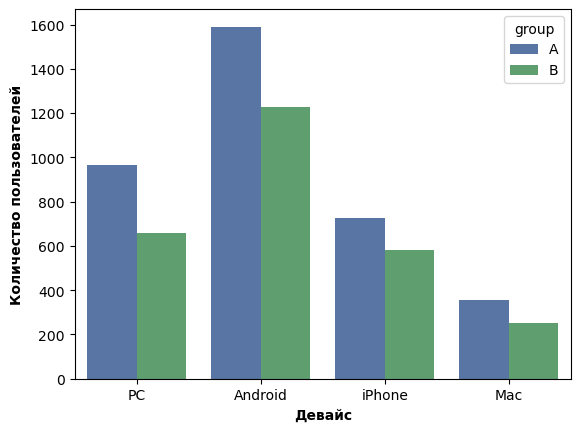

In [196]:
sns.countplot(data = devices, x = 'device', hue = 'group')
plt.xlabel('Девайс', weight = 'bold')
plt.ylabel('Количество пользователей', weight = 'bold');

Как видим, распределение пользователей различных групп по тому, с какого устройства они пользовались сайтом также равномерное

Проверим, как события распределены в двух группах по дням

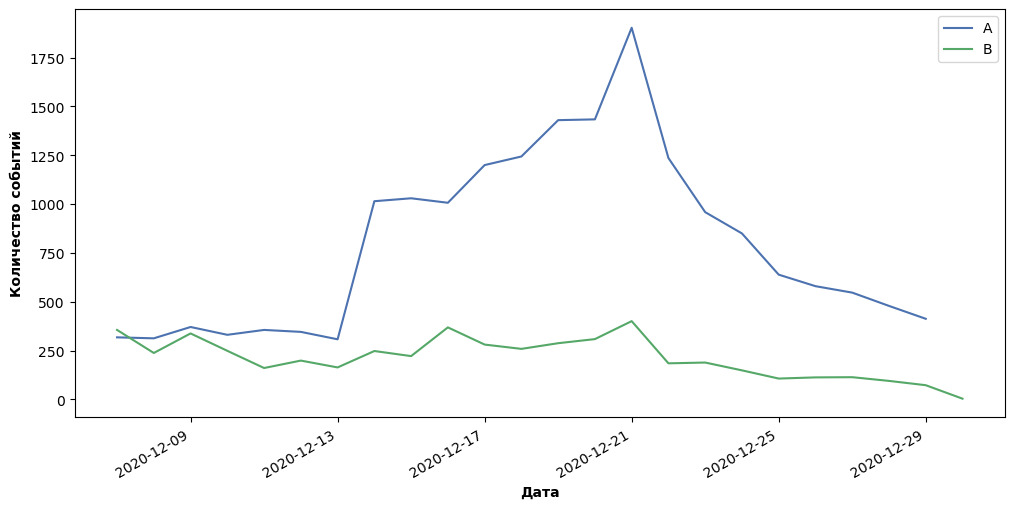

In [197]:
group_a = df[df.group == 'A']
group_b = df[df.group == 'B']
group_a['event_date'] = group_a['event_dt'].dt.date
group_b['event_date'] = group_b['event_dt'].dt.date

group_a = group_a.groupby('event_date')['event_name'].count()
group_b = group_b.groupby('event_date')['event_name'].count()

fig = plt.figure(figsize = (12, 6))

sns.lineplot(group_a, label = 'A')
sns.lineplot(group_b, label = 'B')
plt.gcf().autofmt_xdate()
plt.legend()
plt.xlabel('Дата', weight = 'bold')
plt.ylabel('Количество событий', weight = 'bold');

Здесь заметна **неравномерность** в количестве событий между двумя группами.

Начиная с 13 декабря количество операций для группы А начало расти и достигло пика 21 декабря, после чего пошло на спад. <br>
Количество событий в группе B до 21 декабря колебалось в диапазоне 200 - 300, после чего пошло на спад.

Спад после 21 декабря можно объяснить тем, что после этого числа в обе группы больше не добавлялись новые пользователи. <br>
Причину такого пика по количеству событий для группы А объяснить сложнее, одна из возможных версий: пользователи старой воронки долго не могли определиться с покупкой, возможно откладывали ее на потом, или просматривали большое количество разных товаров, добавляя их всех в корзину.

**Теперь рассмотрим изменение конверсии на разных этапах воронки**

In [198]:
# Создадим для двух групп отдельные таблицы
funnel_a = df[df.group == 'A'].groupby('event_name', as_index = False).agg({'event_dt':'count','user_id':'nunique'})
funnel_a.columns = ['event_name', 'event_count', 'unique_user']
funnel_b = df[df.group == 'B'].groupby('event_name', as_index = False).agg({'event_dt':'count','user_id':'nunique'})
funnel_b.columns = ['event_name', 'event_count', 'unique_user']

# Введем порядок для этапов воронки
order = ['login', 'product_page', 'product_cart', 'purchase']
funnel_a['event_name'] = pd.Categorical(funnel_a['event_name'], categories = order, ordered = True)
funnel_b['event_name'] = pd.Categorical(funnel_b['event_name'], categories = order, ordered = True)

funnel_a = funnel_a.sort_values('event_name')
funnel_b = funnel_b.sort_values('event_name')

In [199]:
funnel_a

,event_name,event_count,unique_user
0,login,8124,2604
2,product_page,5227,1685
1,product_cart,2422,782
3,purchase,2536,833


In [200]:
funnel_b

,event_name,event_count,unique_user
0,login,2471,877
2,product_page,1327,493
1,product_cart,653,244
3,purchase,660,249


Количество **уникальных пользователей** в группе B много меньше, чем в группе A, посмотрим сколько пользователей в двух группах были добавлены в тест, но ни разу не зашли на сайт

In [201]:
df[df.event_name.isna()].group.value_counts()

group
B    1840
A    1030
Name: count, dtype: int64

В нашем тесте в группу А попало больше пользователей чем в группу B, несмотря на это из группы B на сайт ни разу не зашло почти в два раза больше пользователей чем из группы A.

Причиной этого могут быть технические проблемы, с которыми столкнулись только пользователи с новой платежной воронкой.

***
Построим визуалиация для **воронки конверсии** для двух групп

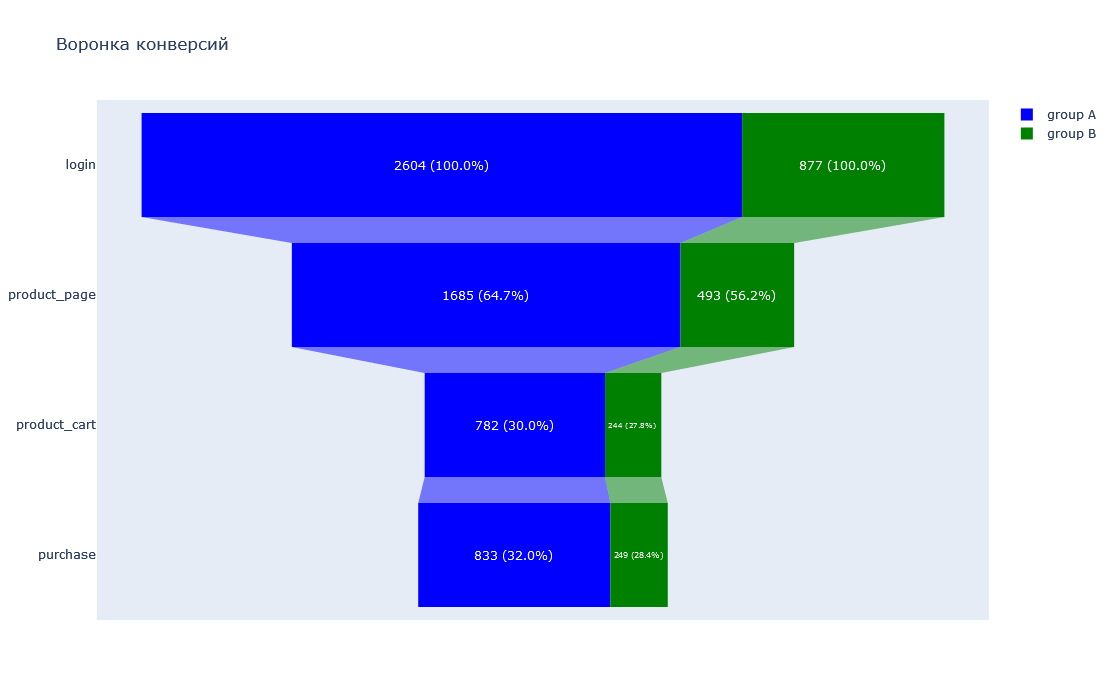

In [207]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'group A',
    y = funnel_a.event_name,         # Этапы воронки
    x = funnel_a.unique_user,       # Значения для группы A
    texttemplate="%{value} (%{percentInitial:.1%})",
    marker = {"color": "blue"}  # Цвет для группы A
))

# Построение воронки для группы B
fig.add_trace(go.Funnel(
    name = 'group B',
    y = funnel_b.event_name,         # Этапы воронки
    x = funnel_b.unique_user,       # Значения для группы B
    texttemplate="%{value} (%{percentInitial:.1%})",
    marker = {"color": "green"}  # Цвет для группы B
))

fig.update_layout(
    height=700,  # Увеличиваем высоту графика
    title="Воронка конверсий"
)

<div style="border:solid black 4px; padding: 10px">

Мы более детально проанализировали данные и увидели:
- Пользователи из двух групп **равномерно распределены** по дате добавления в тест
- Пользователи из группы А совершали на сайте **большее** количество действий
- Пользователи **равномерно распределены** по тому, с какого устройства они регистрировались
- Количество действий совершаемое пользователями из группы А в один день начало сильно увеличиваться после 13 декабря, чего не было замечено за группой B
- Группа А имеет **лучшие показатели конверсии** по сравнению с группой B на всех этапах воронки. По итогу до покупки в группе A дошло 32% пользователей, а в группе B 28%

</div>

## A/B тестирование

Создадим сводную таблицу по конверсии пользователей

In [203]:
users_pivot = df.pivot_table(
    index = 'event_name',
    values = 'user_id',
    columns = 'group',
    aggfunc = lambda x: x.nunique()
).reset_index()

In [204]:
users_pivot['event_name'] = pd.Categorical(users_pivot['event_name'], categories = order, ordered = True)
users_pivot = users_pivot.sort_values('event_name')
users_pivot

group,event_name,A,B
0,login,2604,877
2,product_page,1685,493
1,product_cart,782,244
3,purchase,833,249


### Проверка гипотез о равенстве конверсий с помощью z-теста
Проведем сравнение конверсии для всех этапов воронки для двух групп

**Нулевая гипотеза:** Конверсии в двух группах равны <br>
**Альтернативная гипотеза:** Конверсия для группы B выше

Здесь мы рассматриваем одностороннюю гипотезу, так как нам не важно если конверсия в группе A по итогу выше больше конверсии группы B <br>
**Уровень значимость alpha:** Так как мы проверяем в одном тесте не одну, а сразу три гипотезу, то стоит использовать поправку Бонферонни. Итоговый уровень значимости будет **0.05/3**

In [205]:
# Функция для проверки гипотезы о равенстве дисперсий
def check_hypo(pivot_table, first_event, second_event, alpha):
    print(f'Проверяем гипотезу о равенстве конверсий на этапе воронки \033[1m{first_event} - {second_event}\033[0m')
    
    total = [
        users_pivot[(users_pivot.event_name == first_event)].iloc[0, 1] + users_pivot[(users_pivot.event_name == second_event)].iloc[0, 1],
        users_pivot[(users_pivot.event_name == first_event)].iloc[0, 2] + users_pivot[(users_pivot.event_name == second_event)].iloc[0, 2]
    ]
    
    succ = [
        users_pivot[(users_pivot.event_name == second_event)].iloc[0, 1],
        users_pivot[(users_pivot.event_name == second_event)].iloc[0, 2]
    ]
    p_val = proportions_ztest(succ, total, value = 0, alternative = 'smaller')[1]

    if p_val < alpha:
        print(f'Мы \033[1mотвергаем\033[0m гипотезу о равенстве долей, так как p-value:{p_val} < уровня значимость alpha \n')
    else:
        print(f'Мы \033[1mне можем отвергнуть\033[0m нулевую гипотезу о равенстве средних, так как p-value:{p_val} > уровня значимость alpha \n')

In [206]:
for i in range(3):
    first_event = order[i]
    second_event = order[i+1]
    check_hypo(users_pivot, first_event, second_event, alpha = 0.05/3)

Проверяем гипотезу о равенстве конверсий на этапе воронки login - product_page
Мы не можем отвергнуть нулевую гипотезу о равенстве средних, так как p-value:0.9855998769717249 > уровня значимость alpha 

Проверяем гипотезу о равенстве конверсий на этапе воронки product_page - product_cart
Мы не можем отвергнуть нулевую гипотезу о равенстве средних, так как p-value:0.2359817914078255 > уровня значимость alpha 

Проверяем гипотезу о равенстве конверсий на этапе воронки product_cart - purchase
Мы не можем отвергнуть нулевую гипотезу о равенстве средних, так как p-value:0.6615747309627917 > уровня значимость alpha 



Как мы видим ни одна из гипотез о равенстве средних с односторонней альтернативой мы не отвергаем. <br>
Мы можем сделать вывод, что новая платежная воронка не продемонстрировала значимого улучшения на уровне значимости **0.05/3**

## Общие выводы

<div style="border:solid black 4px; padding: 10px">

Анализ результатов проведенного A/B тестирования показывает **отсутствие статистически значимой разницы** между конверсией в двух группах на каждом этапе воронки.

**Особенности данных:**
- Количество пользователей в двух группах разное: 3634 попало в группу А и 2717 в группу B.
- Из тех пользователей, что попали в тестирование только **71%** взаимодействовали с сайтом для группы А и **лишь 32%** для группы B. Это может указывать на некорректность распределения пользователей по выборкам. В группе А пользователи были намного активнее.
- В каждый день теста кроме первого количество действий пользователей группы А превышало количество действий пользователей из группы B. В частности 21 декабря, пользователи из группы А произвели на сайте в 4.7 раз больше операций.

**Итоговые значения конверсий:** <br>
Группа А: product_page (64.7%), product_cart(30.0%), purchase(32.0%) <br>
Группа B: product_page (56.2%), product_cart(27.8%), purchase(28.4%) <br>

Проведя тест, можно сказать что старая модель платежной воронки оказалась лучше. Однако в тесте замечаны особенности, из-за которых его можно считать некорректным.

</div>